In [16]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torchio as tio
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from functions import *

In [17]:
metaData = pd.read_csv('../metaDataTrain.csv')
metaDataClean = metaData.iloc
subject_list = load_training_dataset(metaDataClean)

## Let us construct the features vectors

In [18]:
features = np.zeros((100, 12))  ## there are 5 features and 20 subjects per training class

features_metadata = select_row_x_and_y_from_table(metaDataClean, 2, 3)

## adding into features vectors
#features[:,:2] = features_metadata

Let us add volume information to feature vectors

In [19]:
volumes_0_ed = []
volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_0_es = []
volumes_1_es = []
volumes_2_es = []
volumes_3_es = []
   
for i in range(0, 100):
    subject = subject_list[i]
    
    ed_view = subject.ed_seg
    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + get_volume(ed_view, 3)
    volumes_0_ed.append(get_volume(ed_view, 0)/sum_volumes)
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(get_volume(ed_view, 3)/sum_volumes)

    es_view = subject.es_seg
    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + get_volume(es_view, 3)
    volumes_0_es.append(get_volume(es_view, 0)/sum_volumes)
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(get_volume(es_view, 3)/sum_volumes)

volumes_0_ed = np.array([volumes_0_ed]).flatten()
volumes_1_ed = np.array([volumes_1_ed]).flatten() 
volumes_2_ed = np.array([volumes_2_ed]).flatten() 
volumes_3_ed = np.array([volumes_3_ed]).flatten() 

volumes_0_es = np.array([volumes_0_es]).flatten()
volumes_1_es = np.array([volumes_1_es]).flatten() 
volumes_2_es = np.array([volumes_2_es]).flatten() 
volumes_3_es = np.array([volumes_3_es]).flatten() 

######### new features
ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed


ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es

for i, new_col in enumerate([ratioRL_ed[:], ratioRL_es[:], ratioML_ed[:], ratioML_es[:], ejection_fraction_right[:], volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], ejection_fraction_left[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    features[:,i] = new_col

Let us just give our explicit class vector

In [20]:
classes = np.zeros((100))
classes[:20] = 2
classes[20:40] = 3
classes[40:60] = 1
classes[60:80] = 0
classes[80:100] = 4
classes = classes.astype('int')

## Time to learn...

A simple linear fully connected model

In [21]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 100)
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, 5)

        self.dropout = nn.Dropout(0.2)
        self.norm1 = nn.BatchNorm1d(100)


    def forward(self, xb):
        out = self.linear1(xb)        
        out = F.leaky_relu(out)
        out = self.dropout(out)
        out = self.norm1(out)
        out = self.linear2(out)
        out = F.leaky_relu(out)
        out = self.dropout(out)
        out = self.norm1(out)
        out = self.linear3(out)
        out = F.softmax(out, dim = 1)
        return out

In [22]:
model = LinearModel()

scaler = StandardScaler().fit(features)

features_scaled = scaler.transform(features)
features_scaled, classes = shuffle(features_scaled, classes, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(features_scaled, classes, test_size=0.2, random_state=42)

X_train = torch.tensor(features_scaled, dtype=torch.float32)
y_train = torch.tensor(classes, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

In [23]:
epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = F.cross_entropy
val_loss, total, val_acc = evaluate(model, loss_fn, X_val, y_val, metric = accuracy)
fit2(epochs, model, loss_fn, optimizer, X_train, y_train, X_val, y_val, metric = accuracy)

Epoch [1/50], Loss: 1.6096, accuracy: 0.2500
Epoch [2/50], Loss: 1.5290, accuracy: 0.5000
Epoch [3/50], Loss: 1.5115, accuracy: 0.4500
Epoch [4/50], Loss: 1.4481, accuracy: 0.5500
Epoch [5/50], Loss: 1.4148, accuracy: 0.6500
Epoch [6/50], Loss: 1.3905, accuracy: 0.6000
Epoch [7/50], Loss: 1.3287, accuracy: 0.8500
Epoch [8/50], Loss: 1.2745, accuracy: 0.7500
Epoch [9/50], Loss: 1.2723, accuracy: 0.8000
Epoch [10/50], Loss: 1.2554, accuracy: 0.8000
Epoch [11/50], Loss: 1.2155, accuracy: 0.9000
Epoch [12/50], Loss: 1.1782, accuracy: 0.9500
Epoch [13/50], Loss: 1.2160, accuracy: 0.8000
Epoch [14/50], Loss: 1.1535, accuracy: 0.9000
Epoch [15/50], Loss: 1.1532, accuracy: 0.9000
Epoch [16/50], Loss: 1.1424, accuracy: 0.9000
Epoch [17/50], Loss: 1.1011, accuracy: 0.9500
Epoch [18/50], Loss: 1.1577, accuracy: 0.9500
Epoch [19/50], Loss: 1.0853, accuracy: 0.9500
Epoch [20/50], Loss: 1.0783, accuracy: 0.9500
Epoch [21/50], Loss: 1.0859, accuracy: 0.9500
Epoch [22/50], Loss: 1.0738, accuracy: 0.95

In [24]:
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

Text(0.5, 1.0, 'Prediction on val set for ada LR 10D. 100% accuracy')

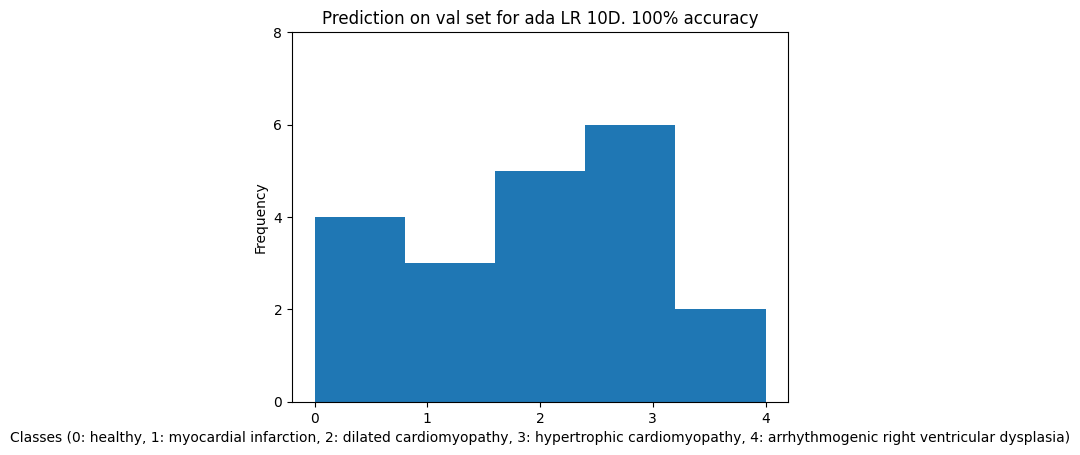

In [25]:
_, preds = torch.max(model(X_val), dim = 1)
val_acc = (preds == y_val).sum().item()/len(y_val)
y_val_preds = preds
plt.hist(tensor_to_numpy(y_val_preds), bins=5)
plt.xticks([0,1,2,3,4])
plt.yticks([0, 2, 4, 6, 8])
plt.xlabel('Classes (0: healthy, 1: myocardial infarction, 2: dilated cardiomyopathy, 3: hypertrophic cardiomyopathy, 4: arrhythmogenic right ventricular dysplasia)')
plt.ylabel('Frequency')
plt.title("Prediction on val set for ada LR 10D. {:.0f}% accuracy".format(val_acc*100))

## Now let us test that model on the test dataset

In [26]:
test_features = np.zeros((50, 12))

In [27]:
test_subject_list1 = load_filled_test_dataset()
test_subject_list = load_test_dataset()

volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []

spacings_test = np.zeros((50))
   
for i in range(0, 50):
    subject1 = test_subject_list1[i]

    subject_ed = test_subject_list[i].ed_seg.data.numpy()[0]
    ed_view = subject1.ed_seg

    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + int((lv_volume(subject_ed == 2)).sum())
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(int((lv_volume(subject_ed == 2)).sum())/sum_volumes)

    subject_es = test_subject_list[i].es_seg.data.numpy()[0]
    es_view = subject1.es_seg

    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + int((lv_volume(subject_es == 2)).sum())
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(int((lv_volume(subject_es == 2)).sum())/sum_volumes)


volumes_1_ed = np.array([volumes_1_ed]).flatten()
volumes_2_ed = np.array([volumes_2_ed]).flatten()
volumes_3_ed = np.array([volumes_3_ed]).flatten()

volumes_1_es = np.array([volumes_1_es]).flatten()
volumes_2_es = np.array([volumes_2_es]).flatten()
volumes_3_es = np.array([volumes_3_es]).flatten()


ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed


ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es


for i, new_col in enumerate([ratioRL_ed[:], ratioRL_es[:], ratioML_ed[:], ratioML_es[:], ejection_fraction_right[:], volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], ejection_fraction_left[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    test_features[:,i] = new_col

We can now predict

Text(0, 0.5, 'Frequency')

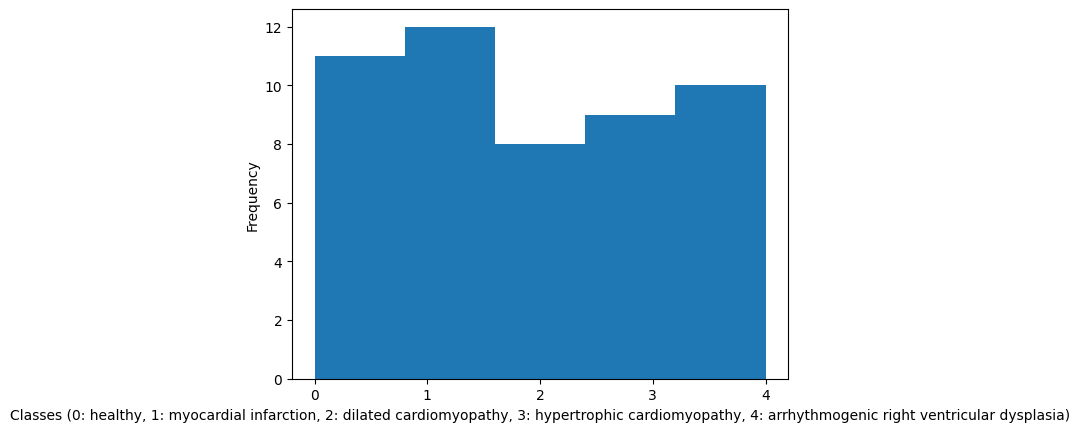

In [28]:
test_features_scaled = scaler.transform(test_features)

X_test = torch.tensor(test_features_scaled, dtype=torch.float32)

test_preds = model(X_test)
test_preds = torch.max(test_preds, dim = 1)[1]
test_preds = tensor_to_numpy(test_preds)

plt.hist(np.array(test_preds), bins=5)
plt.xticks([0,1,2,3,4])
plt.xlabel('Classes (0: healthy, 1: myocardial infarction, 2: dilated cardiomyopathy, 3: hypertrophic cardiomyopathy, 4: arrhythmogenic right ventricular dysplasia)')
plt.ylabel('Frequency')


And write down for submission

In [29]:
test_preds

array([2, 4, 0, 3, 4, 1, 0, 0, 4, 4, 3, 3, 0, 0, 0, 4, 2, 3, 1, 0, 4, 0,
       3, 3, 1, 2, 1, 4, 2, 4, 1, 4, 3, 2, 0, 3, 1, 3, 1, 0, 2, 1, 2, 1,
       4, 2, 0, 1, 1, 1], dtype=int64)

In [30]:
df = pd.read_csv("../SampleSubmission.csv")
df.iloc[:, 1] = test_preds
df.to_csv("../SampleSubmission.csv", index=False)